<a href="https://colab.research.google.com/github/pawan-cpu/Learn-Python-with-Pawan-Kumar/blob/main/L17Jan__2022_01_17_pawan_lesson54.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 54: Ordinary Least Squares



|Particulars|Description|
|-|-|
|**Topics Covered**|Matrices|
||Matrix Multiplication|
||Matrices in Python|
|||
|**Lesson Description**|A student learns the concept of ordinary least squares method in detail.|
|||
|**Lesson Duration**|45 minutes|
|||
|**Learning Outcomes**|Dive deep into ordinary least squares method.|
|||



---

### Teacher-Student Tasks

In this class we will learn the concept of **ordinary least squares** method. In the process, we will also learn the concepts of matrices.

---

In [ ]:
# Run the code cell.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Loading the dataset.
csv_file = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/whitehat-ds-datasets/air-quality/AirQualityUCI.csv'
df = pd.read_csv(csv_file, sep=';')

# Dropping the 'Unnamed: 15' & 'Unnamed: 16' columns.
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], axis=1) 

# Dropping the null values.
df = df.dropna()

# Creating a Pandas series containing 'datetime' objects.
dt_series = pd.Series(data = [item.split("/")[2] + "-" + item.split("/")[1] + "-" + item.split("/")[0] for item in df['Date']], index=df.index) + ' ' + pd.Series(data=[str(item).replace(".", ":") for item in df['Time']], index=df.index)
dt_series = pd.to_datetime(dt_series)

# Remove the Date & Time columns from the DataFrame and insert the 'dt_series' in it.
df = df.drop(columns=['Date', 'Time'], axis=1)
df.insert(loc=0, column='DateTime', value=dt_series)

# Get the Pandas series containing the year values as integers.
year_series = dt_series.dt.year

# Get the Pandas series containing the month values as integers.
month_series = dt_series.dt.month

# Get the Pandas series containing the day values as integers.
day_series = dt_series.dt.day

# Get the Pandas series containing the days of a week, i.e., Monday, Tuesday, Wednesday etc.
day_name_series = dt_series.dt.day_name()

# Add the 'Year', 'Month', 'Day' and 'Day Name' columns to the DataFrame.
df['Year'] = year_series
df['Month'] = month_series
df['Day'] = day_series
df['Day Name'] = day_name_series

# Sort the DataFrame by the 'DateTime' values in the ascending order. Also, display the first 10 rows of the DataFrame.
df = df.sort_values(by='DateTime')

# Create a function to replace the commas with periods in a Pandas series.
def comma_to_period(series):
    new_series = pd.Series(data=[float(str(item).replace(',', '.')) for item in series], index=df.index)
    return new_series

# Apply the 'comma_to_period()' function on the ''CO(GT)', 'C6H6(GT)', 'T', 'RH' and 'AH' columns.
cols_to_correct = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'] # Create a list of column names.
for col in cols_to_correct: # Iterate through each column
    df[col] = comma_to_period(df[col]) # Replace the original column with the new series.

# Remove all the columns from the 'df' DataFrame containing more than 10% garbage value.
df = df.drop(columns=['NMHC(GT)', 'CO(GT)', 'NOx(GT)', 'NO2(GT)'], axis=1)

# Create a new DataFrame containing records for the years 2004 and 2005.
aq_2004_df = df[df['Year'] == 2004]
aq_2005_df = df[df['Year'] == 2005]

# Replace the -200 value with the median values for each column having indices between 1 and -4 (excluding -4) for the 2004 year DataFrame.
for col in aq_2004_df.columns[1:-4]:
  median = aq_2004_df.loc[aq_2004_df[col] != -200, col].median()
  aq_2004_df[col] = aq_2004_df[col].replace(to_replace=-200, value=median)

# Repeat the same exercise for the 2005 year DataFrame.
for col in aq_2005_df.columns[1:-4]:
  median = aq_2005_df.loc[aq_2005_df[col] != -200, col].median()
  aq_2005_df[col] = aq_2005_df[col].replace(to_replace=-200, value=median)

# Group the DataFrames about the 'Month' column.
group_2004_month = aq_2004_df.groupby(by='Month')
group_2005_month = aq_2005_df.groupby(by='Month')

# Concatenate the two DataFrames for 2004 and 2005 to obtain one DataFrame.
df = pd.concat([aq_2004_df, aq_2005_df])

# Information of the DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       9357 non-null   datetime64[ns]
 1   PT08.S1(CO)    9357 non-null   float64       
 2   C6H6(GT)       9357 non-null   float64       
 3   PT08.S2(NMHC)  9357 non-null   float64       
 4   PT08.S3(NOx)   9357 non-null   float64       
 5   PT08.S4(NO2)   9357 non-null   float64       
 6   PT08.S5(O3)    9357 non-null   float64       
 7   T              9357 non-null   float64       
 8   RH             9357 non-null   float64       
 9   AH             9357 non-null   float64       
 10  Year           9357 non-null   int64         
 11  Month          9357 non-null   int64         
 12  Day            9357 non-null   int64         
 13  Day Name       9357 non-null   object        
dtypes: datetime64[ns](1), float64(9), int64(3), object(1)
memory usage: 1.1+

The description for all the columns containing data for air pollutants, temperature, relative humidity and absolute humidity is provided below.


|Columns|Description|
|-|-|
|PT08.S1(CO)|PT08.S1 (tin oxide) hourly averaged sensor response (nominally $\text{CO}$ targeted)|
|C6H6(GT)|True hourly averaged Benzene concentration in $\frac{\mu g}{m^3}$|
|PT08.S2(NMHC)|PT08.S2 (titania) hourly averaged sensor response (nominally $\text{NMHC}$ targeted)|
|PT08.S3(NOx)|PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_x$ targeted)|
|PT08.S4(NO2)|PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_2$ targeted)|
|PT08.S5(O3) |PT08.S5 (indium oxide) hourly averaged sensor response (nominally $\text{O}_3$ targeted)|
|T|Temperature in Â°C|
|RH|Relative Humidity (%)|
|AH|AH Absolute Humidity|

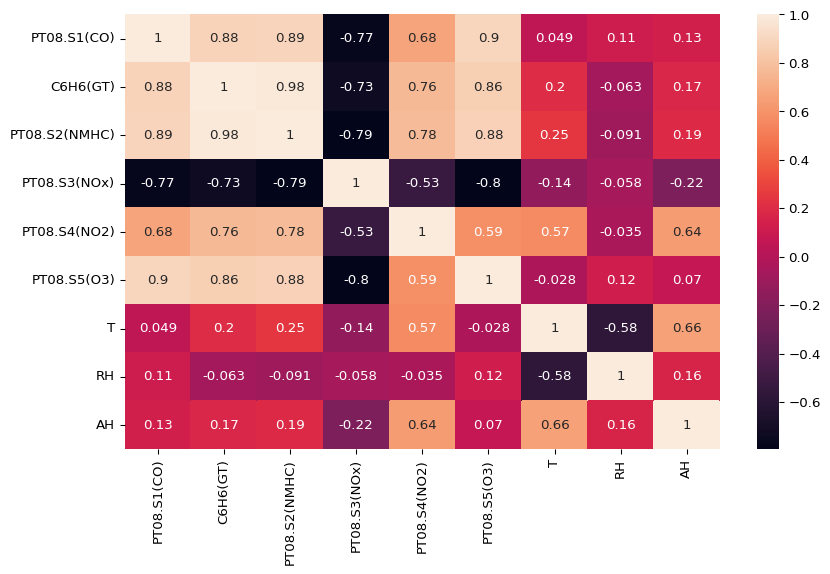

In [ ]:
# Heatmap to pinpoint the columns in the 'df' DataFrame exhibiting high correlation.
corr_df = df.iloc[:, 1:-4].corr()
plt.figure(figsize = (10, 6), dpi = 96)
sns.heatmap(data = corr_df, annot = True) # 'annot=True' fills the R values in the heatmap cells.
plt.show()

---

#### Multiple Linear Regression Model Using `sklearn` Module


In [ ]:
# S1.2: Build a linear regression model using the sklearn module by including all the features listed above.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

features = list(df.columns.values[1:-1])
features.remove('RH')

X = df[features]
y = df['RH']

# Splitting the DataFrame into the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Build linear regression model using the 'sklearn.linear_model' module.
sklearn_lin_reg = LinearRegression()
sklearn_lin_reg.fit(X_train, y_train_reshaped)

# Print the value of the intercept i.e. beta-sub-0.
print("\nConstant".ljust(15, " "), f"{sklearn_lin_reg.intercept_[0]:.6f}") # Soon you will get to know why rounding-off to 6 decimal places.

# Print the names of the of the features along with the values of their correspding coefficients.
for item in list(zip(X.columns.values, sklearn_lin_reg.coef_[0])):
  print(f"{item[0]}".ljust(15, " "), f"{item[1]:.6f}") # Soon you will get to know why rounding-off to 6 decimal places.


Constant       -15028.451823
PT08.S1(CO)     0.014833
C6H6(GT)        -0.903464
PT08.S2(NMHC)   -0.005881
PT08.S3(NOx)    0.001503
PT08.S4(NO2)    0.026497
PT08.S5(O3)     -0.001066
T               -2.354919
AH              29.551742
Year            7.505153
Month           1.167861
Day             0.035232


In [ ]:
# S1.3: Evalute the linear regression model using the 'r2_score', 'mean_squared_error' & 'mean_absolute_error' functions of the 'sklearn' module.
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_train_pred = sklearn_lin_reg.predict(X_train)
y_test_pred = sklearn_lin_reg.predict(X_test)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train_reshaped, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train_reshaped, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train_reshaped, y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_reshaped, y_train_pred):.3f}")
      
print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test_reshaped, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test_reshaped, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test_reshaped, y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reshaped, y_test_pred):.3f}")

Train Set
--------------------------------------------------
R-squared: 0.879
Mean Squared Error: 35.116
Root Mean Squared Error: 5.926
Mean Absolute Error: 4.572


Test Set
--------------------------------------------------
R-squared: 0.879
Mean Squared Error: 34.702
Root Mean Squared Error: 5.891
Mean Absolute Error: 4.564


---

#### The `statsmodels.api` Module

In [ ]:
# Build a linear regression model using the 'statsmodels.api' module.
import statsmodels.api as sm

# Create data frames for the features and target again and also split them into the train and test sets.
X = df[features]
y = df['RH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

# Add a constant to get an intercept
X_train_sm = sm.add_constant(X_train)

# Fit the regression line using 'OLS'
lr = sm.OLS(y_train, X_train_sm).fit()

# Print the parameters, i.e. the intercept and the slope of the regression line fitted
lr.params

const           -15028.451823
PT08.S1(CO)          0.014833
C6H6(GT)            -0.903464
PT08.S2(NMHC)       -0.005881
PT08.S3(NOx)         0.001503
PT08.S4(NO2)         0.026497
PT08.S5(O3)         -0.001066
T                   -2.354919
AH                  29.551742
Year                 7.505153
Month                1.167861
Day                  0.035232
dtype: float64

The above values for the constant and the coefficients of all the features are almost the same as the ones obtained through the `sklearn` linear regression model.

In [ ]:
# Performing a summary operation lists out all the different parameters of the regression line fitted
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     4115.
Date:                Mon, 17 Jan 2022   Prob (F-statistic):               0.00
Time:                        10:40:24   Log-Likelihood:                -20050.
No. Observations:                6269   AIC:                         4.012e+04
Df Residuals:                    6257   BIC:                         4.020e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.503e+04   1240.167    -12.118

---

#### Task 1: Ordinary Least Squares (OLS)

Consider the regression equation

$$Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \dots + \beta_k x_k + \epsilon$$

where 

- $x_1, x_2, x_3, \dots , x_k$ are independent variables or features

- $Y$ is the response to the independent variable (or predicted value or dependent variable)

- $\beta_0, \beta_1, \beta_2, \dots, \beta_k$ are the corresponding regression coefficients of the independent variables

- **$\epsilon$** is the random error obtained along with the predicted value which follows normal distribution with mean $0$ and some standard deviation of $\sigma$


The parameters $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ and $\sigma$ are assumed to be unknown and must be estimated from the data, which we shall suppose will consist of the values of $Y_1, Y_2, Y_3, \dots , Y_n$ where $Y_i$ is the response level corresponding to the $k$ features $x_{i1}, \dots , x_{i2}, \dots , x_{ik}$ . That is, the $Y_i$ are related to these features through

$$E[Y_i] = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \beta_3 x_{i3} + \dots + \beta_k x_{ik}$$

where 

- $E[Y_i]$ means **expected value** for an instance $i$. In simple terms, instance or $i$ denotes a row in a data frame

- $x_{i1}$ denotes item at the $i^{\text{th}}$ row in the $1^{\text{st}}$ column in a data frame having only features

- $x_{i2}$ denotes item at the $i^{\text{th}}$ row in the $2^{\text{nd}}$ column in a data frame having only features

- $x_{i3}$ denotes item at the $i^{\text{th}}$ row in the $3^{\text{rd}}$ column in a data frame having only features

  $\dots$

- $x_{ik}$ denotes item at the $i^{\text{th}}$ row in the $k^{\text{th}}$ column in a data frame having only features

For e.g., in the `X` DataFrame there are $9357$ rows. So let $x_1, x_2, x_3, \dots , x_{11}$ denote $\text{CO}, \text{C}_6 \text{H}_6, \text{NMHC}, \dots, \text{day}$ respectively.

Now let's display the first-three and last-three rows of the features.


In [ ]:
# S1.1: Display the first-three rows.
X_train.head(3)

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,AH,Year,Month,Day
2653,1384.0,23.5,1391.0,552.0,2316.0,1548.0,24.7,1.5201,2004,6,29
5471,1277.0,11.8,1043.0,614.0,1631.0,1155.0,25.0,1.5630,2004,10,24
5681,1570.0,32.9,1617.0,426.0,2170.0,1944.0,22.1,1.4851,2004,11,2


In [ ]:
# S1.2: Display the last-three rows.
X_test.head(3)


,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,AH,Year,Month,Day
2973,933.0,6.4,831.0,888.0,1514.0,710.0,26.0,1.1509,2004,7,12
3396,894.0,4.9,761.0,862.0,1504.0,768.0,23.0,1.3849,2004,7,30
4372,1226.0,14.6,1138.0,862.0,1481.0,1419.0,25.1,1.0131,2004,9,8


So $E[Y_1]$ denotes the predicted value for the first row values in the `X` DataFrame containing features i.e.

$$E[Y_1] = \beta_0 + \beta_1 \times 1360.0 + \beta_2 \times 11.9 + \beta_3 \times 1046.0 + \dots + \beta_{11} \times 10$$

Similarly,

$$E[Y_2] = \beta_0 + \beta_1 \times 1292.0 + \beta_2 \times 9.4 + \beta_3 \times 955.0 + \dots + \beta_{11} \times 10$$

$$E[Y_3] = \beta_0 + \beta_1 \times 1402.0 + \beta_2 \times 9.0 + \beta_3 \times 939.0 + \dots + \beta_{11} \times 10$$

$$\vdots$$

$$E[Y_{9357}] = \beta_0 + \beta_1 \times 1071.0 + \beta_2 \times 11.9 + \beta_3 \times 1047.0 + \dots + \beta_{11} \times 4$$

*There are a total of 9357 rows in the dataset.*

As we said earlier, the difference between the actual and the predicted values should be 0 or close to 0 for an accurate prediction model i.e.

$$Y_1 - E[Y_1] \approx 0$$

$$Y_2 - E[Y_2] \approx 0$$

$$Y_3 - E[Y_3] \approx 0$$

$$\vdots$$

$$Y_N - E[Y_N] \approx 0$$

where $N$ is the total number of instances (or rows in a data frame).

**The OLS says that the sum of squares of all these errors i.e.**

$$J = (Y_1 - E[Y_1])^2 + (Y_2 - E[Y_2])^2 + (Y_3 - E[Y_3])^2 + \dots + (Y_N - E[Y_N])^2$$

**should be the least or minimum.** 

The above expression can be compressed as
$$J = \sum_{i = 1}^{N}(Y_i - E[Y_i])^2$$

So in general, it can be written as

$$J(\beta, x) = \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})^2 $$

where $J(\beta, x)$ denotes the sum of the squared errors is dependent on the coefficients ($\beta_0, \beta_1, \beta_2, \dots, \beta_k$) and features ($x_1, x_2, x_3, \dots , x_k$)


**Note:** Beyond this point, a student should know calculus to understand the subsequent points discussed.

The above function represents a three-dimensional curve similar to the one shown in the image below.

<center><img src = 'https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/14498/versions/1/screenshot.jpg' width = 800></center>

**Image credits:** *https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/14498/versions/1/screenshot.jpg*

To find the points of maxima (peak) or minima (valley), we differentiate a mathematical function w.r.t. independent variable and equate the result obtained to 0 because the slope of a curve at the point of maxima (peak) or minima (valley) is 0. Differentiation (or derivative) represents slope at a point.

In the above equation, all the $x$ quantities are known quantities as we have seen earlier. So the $\beta_0, \beta_1, \beta_2, \dots, \beta_k$ are unknown quantities. Thus, they are independent variables.

Here $\beta_0, \beta_1, \beta_2, \dots, \beta_k$ are independent of each other. Hence, we can do partial differentiation w.r.t. to each of the betas independently.

Let's differentiate $J(\beta, x)$ w.r.t. $\beta_0$. So every other term apart from $\beta_0$ will be treated as a constant. And the differentiation (or derivative) of a constant is 0.

$$\frac{\partial J}{\partial \beta_0} = 2 \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})(-1) = 0$$

$$\Rightarrow \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik}) = 0$$

Similarly, 

$$\frac{\partial J}{\partial \beta_1} = 2 \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})(-x_{i1}) = 0$$

$$\Rightarrow \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})x_{i1} = 0$$

$$\frac{\partial J}{\partial \beta_2} = 2 \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})(-x_{i2}) = 0$$

$$\Rightarrow \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})x_{i2} = 0$$

$$\vdots$$

$$\frac{\partial J}{\partial \beta_k} = 2 \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})(-x_{ik}) = 0$$

$$\Rightarrow \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})x_{ik} = 0$$


On further reducing the above $k + 1$ equations, we get

$$\sum_{i = 1}^{N}Y_i = N \beta_0 + \beta_1 \sum_{i = 1}^{N}x_{i1} + \beta_2 \sum_{i = 1}^{N}x_{i2} +  \dots + \beta_k \sum_{i = 1}^{N} x_{ik}$$

$$\sum_{i = 1}^{N}Y_i x_{i1} = \beta_0 \sum_{i = 1}^{N}x_{i1} + \beta_1 \sum_{i = 1}^{N}x_{i1}^2 + \beta_2 \sum_{i = 1}^{N} x_{i1} x_{i2} + \dots + \beta_k \sum_{i = 1}^{N} x_{i1} x_{ik}$$

$$\vdots$$

$$\sum_{i = 1}^{N}Y_i x_{ik} = \beta_0 \sum_{i = 1}^{N}x_{ik} + \beta_1 \sum_{i = 1}^{N} x_{ik} x_{i1} + \beta_2 \sum_{i = 1}^{N} x_{ik} x_{i2} + \dots + \beta_k \sum_{i = 1}^{N} x_{ik}^2$$


Now we have $k + 1$ linear equations having $k + 1$ unknowns i.e. $\beta_0, \beta_1, \beta_2, \dots, \beta_k$ . By solving these $k + 1$ equations, we can get the beta values. This is exactly the same as solving two linear equations having two unknowns. For e.g., the solution to the two linear equations 

$$8\beta_0 + 7\beta_1 = 38 \space{} \text{and} \space{} 3 \beta_0 - 5 \beta_1 = -1$$

is 
$$\beta_0 = 3 \space{} \text{and} \space{} \beta_1 = 2$$

So all-in-all, **ordinary least  squares** says that **find the values of the coefficients ($\beta_0, \beta_1, \beta_2, \dots, \beta_k$) such that the sum of the squares of differences between the actual values and the predicted values is minimum.**

To solve $k + 1$ linear equations having $k + 1$ unknowns, you need to know matrices.

---

#### Matrices

The linear equations:

$$8 \beta_0 + 7 \beta_1 = 38$$

$$3 \beta_0 - 5 \beta_1 = -1$$

These can also be written in the form of a matrix as:

$$\begin{bmatrix} 8 & 7 \\ 3	& -5	\\\end{bmatrix} \begin{bmatrix} \beta_0 \\ \beta_1 \\\end{bmatrix} = \begin{bmatrix} 38 \\ -1 \\\end{bmatrix}$$

Let's learn what exactly is the above equation.

A matrix is a two-dimensional representation of numbers in the form of rows and columns. Here, 

$$\begin{bmatrix} 8 & 7 \\ 3	& -5	\\\end{bmatrix}$$

This is one matrix of having 2 rows and 2 columns. So its dimension is $2 \times 2$. **The dimension of a matrix shows the number of rows and columns present in a matrix.** Let the above matrix be $X$. So

$$X_{2 \times 2} = \begin{bmatrix} 8 & 7 \\ 3	& -5	\\\end{bmatrix}$$

The matrix $\begin{align} \begin{bmatrix} \beta_0 \\ \beta_1 \\\end{bmatrix} \end{align}$ has 2 rows and 1 column. So its dimension is $2 \times 1$. 

Let it be $B$. So $B_{2 \times 1} = \begin{bmatrix} \beta_0 \\ \beta_1 \\\end{bmatrix}$

And the third matrix $\begin{bmatrix} 38 \\ -1 \\\end{bmatrix}$
also has 2 rows and 1 column. So its dimension is $2 \times 1$ as well. 

Let it be $E$. So $E_{2 \times 1} = \begin{bmatrix} 38 \\ -1 \\\end{bmatrix}$

Hence, we have

$X_{2 \times 2}  B_{2 \times 1} = E_{2 \times 1}$

or

$X B = E$

The left-hand side of the matrix equation 

$$\begin{bmatrix} 8 & 7 \\ 3	& -5	\\\end{bmatrix} \begin{bmatrix} \beta_0 \\ \beta_1 \\\end{bmatrix} = \begin{bmatrix} 38 \\ -1 \\\end{bmatrix}$$

This is the product of two matrices. So let's learn how to multiply two matrices.


---

##### **Matrix Multiplication**

**To multiply two matrices, the number of columns in the first matrix should be the same as the number of rows in the second matrix.**

So in the equation
$$X B = E$$

The matrix $X$ has 2 columns and the matrix $B$ has 2 rows. Hence, the above matrix multiplication is valid.

In general, if the first matrix has $m$ rows and $n$ columns i.e. $X_{m \times n}$ and the second matrix has $n$ rows and $p$ columns i.e. $B_{n \times p}$. Then their product matrix will have $m$ rows and $p$ columns i.e. $E_{m \times p}$ i.e.

$$X_{m \times n} B_{n \times p} = E_{m \times p}$$

**Note:** Matrix multiplication is not commutative i.e. 

$$XB \neq BX$$ 

In this case, 

$$\begin{bmatrix} 8 & 7 \\ 3	& -5	\\\end{bmatrix} \begin{bmatrix} \beta_0 \\ \beta_1 \\\end{bmatrix} \neq \begin{bmatrix} \beta_0 \\ \beta_1 \\\end{bmatrix}\begin{bmatrix} 8 & 7 \\ 3	& -5	\\\end{bmatrix}$$

The right-hand side of the inequation is an invalid multiplication because the first matrix has only 1 column and the second matrix has 2 rows. 

To multiply two matrices, multiply the elements of the

- First row with the first column.

- First row with the second column.

- First row with the third column and so on.

- Second row with the first column.

- Second row with the second column.

- Second row with the third column and so on.

  $\dots$

- $m^{\text{th}}$ row with the first column.

- $m^{\text{th}}$ row with the second column.

- $m^{\text{th}}$ row with the third column and so on.

Therefore we get,

$$\begin{bmatrix} 8 \beta_0 + 7 \beta_1 \\ 3 \beta_0 - 5 \beta_1 \\\end{bmatrix} = \begin{bmatrix} 38 \\ -1 \\\end{bmatrix}$$

Now we have two $2 \times 1$ matrics. Hence when they are equations, we get two linear equations in two variables i.e.

$$8\beta_0 + 7\beta_1 = 38$$

$$3 \beta_0 - 5 \beta_1 = -1$$

But we will learn to solve the equations using the matrices. To find the solutions of the matrix equation

$$\begin{bmatrix} 8 & 7 \\ 3	& -5	\\\end{bmatrix} \begin{bmatrix} \beta_0 \\ \beta_1 \\\end{bmatrix} = \begin{bmatrix} 38 \\ -1 \\\end{bmatrix}$$

We have to convert the $X_{2 \times 2}$ into an **identity matrix**. An identity matrix is a matrix whose diagonal elements are  1  and all the other elements are  0.



---

#### Task 2: Matrices in Python

Before we start learning the identity matrix, let's multiply two matrices using Python.

To create a matrix in Python, use the `matrix()` function of the `numpy` module. Inside the function, pass the elements of a matrix as input. The input is a string, each element of a row is separated by whitespace and each row is separated by a semi-colon.

**Syntax:** `np.matrix('a11 a12 a13; a21 a22 a23')`

where 

- `a11` is the element in the matrix at $1^{\text{st}}$ row and $1^{\text{st}}$ column

- `a12` is the element in the matrix at $1^{\text{st}}$ row and $2^{\text{nd}}$ column

- `a13` is the element in the matrix at $1^{\text{st}}$ row and $3^{\text{rd}}$ column

- `a21` is the element in the matrix at $2^{\text{nd}}$ row and $1^{\text{st}}$ column

- `a22` is the element in the matrix at $2^{\text{nd}}$ row and $2^{\text{nd}}$ column

- `a23` is the element in the matrix at $2^{\text{nd}}$ row and $3^{\text{rd}}$ column

Similarly, you can add more rows and columns to a matrix.

In [ ]:
# S2.1: Create a matrix using the 'matrix()' function of the 'numpy' module.
import numpy as np
print(np.matrix('1 2 3 ;4 5 6'))

[[1 2 3]
 [4 5 6]]


We can also convert a nested Python list into a matrix using the `matrix()` function of the `numpy` module.

In [ ]:
# S2.2: Convert a nested Python list into a matrix using the 'matrix()' function of the 'numpy' module.
np.matrix([[1,2,3 ],[4,5,6]])

matrix([[1, 2, 3],
        [4, 5, 6]])

Now let's multiply the following two matrices to find out the output.

$$\begin{bmatrix} 8 & 7 \\ 3	& -5	\\\end{bmatrix} \begin{bmatrix} 3 \\ 2 \\\end{bmatrix}$$

The output should be

$$\begin{bmatrix} 38 \\ -1 \\\end{bmatrix}$$

To multiply two matrices, you have to use the `matmul()` function of the `numpy` module. It takes two matrices to be multiplied as inputs and returns a new matrix.

In [ ]:
# S2.3: Multiply the above two matrices.
A=np.matrix('8 7 ; 3 -5 ')
B=np.matrix('3;2')
np.matmul(A,B)

matrix([[38],
        [-1]])

**Note:** The number of columns in the first matrix should be the same as the number of rows in the second matrix. Otherwise you will get `ValueError`

In [ ]:
# S2.4: Repeat the above exercise by interchanging the positions of the inputs.
np.matmul(B,A)

ValueError: ignored

Let's stop here. We will continue the next class from the **identity matrix**.

---